# Calculate the GW modes for each exoplanet that has the needed parameters in the dbase.

In [1]:
# Started WEG  20180320. 
# See the gwtools.py which has utility and strain functions in it
# and ExopDBase notebook that can download a new csv exop database.

# References
P. Amaro-Seoane et al. "Triplets of supermassive black holes: astrophysics, gravitational waves and detection," MNRAS 402 2308-2320 (2010).

P. C. Peters and J. Mathews, "Gravitational Radiation from Point Masses in a Keplerian Orbit," Phys. Rev. 131 (1963) 435-440.

Michele Maggiore, "Gravitational Waves. Volume 1: Theory and Experiments," Oxford Univ. Press, 2008.

Shane Larson, "Sensitivity Curves for ..."  http://www.srl.caltech.edu/~shane/sensitivity/

Neil Cornish and Travis Robson, "The construction and use of LISA sensitivy curves," https://arxiv.org/abs/1803.01944

In [2]:
import sys, os
import numpy as np
import urllib as ul
import pandas as pd
import gwTools as gwt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.interpolate as spint

# CalTech Exop Database (from ExopDBase notebook)

## Update or not from the CalTech database.  Directories for the dbase and to save plots.

In [3]:
thisDir = os.getcwd()  # This is the /python subdirectory.
csvDir = thisDir + '/../dbases/'  # Will the /../ work on non-Unices?
pixDir = thisDir + '/../pix/'

## Search string, might want RA and DEC also.

In [4]:
# The search URL and search string/request. 
exopURL = \
  "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-\
nstedAPI?" ;

#searchString = \
#"table=exoplanets&select=pl_hostname,ra,dec&order=dec&format=CSV";*)

# The Below does NOT have right ascension and declination.  Will likely want them for further work.
# Can add later in its own Panda dataframe and/or merge into the main one in GWStrainPlotsSNR.
# variables come from NASA Exoplanet Archive, the keywords are defined here: 
#https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html 
searchString = \
  "table=exoplanets&select=pl_hostname,pl_letter,pl_discmethod,pl_\
orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_\
plx&order=dec&format=CSV";

## Flags for fresh import and for saving the CSV file.

In [5]:
# Set to True to re-read the EXop Dbase from Caltech.  False to use csvFname below.
newImport = False;
#newImport = False;
saveFile = True;# Future work, when we do NOT want an intermediate file here would set to False, but needs coding.
#saveFile = False;

In [6]:
# csv file below was downloaded earlier with code below.  newImport = False to use it.  Or new csv will be
# created.  This takes a few seconds.
csvFileName = csvDir + 'exopP_20180408_141319.csv'  
if newImport and saveFile:
    myDateTimeStamp = gwt.dateTimeStamp()  # See the gwtools.py file with this and other functions in it.
    csvFileName = csvDir + 'exopP_' + myDateTimeStamp + '.csv'
    ofile = open(csvFname, 'w')
    with ul.request.urlopen(exopURL + searchString) as response:
        for aline in response:
            ofile.write( aline.decode('utf-8') )  # byte-string needs to be decoded. utf-8 is common encoding
    ofile.close()
    print('Saved database file ' + csvFileName)


## Read the CSV file and drop the rows/exops with NaN in the important fields.  See ExopDBase.ipynb and re-run it for updating the dbase.

In [7]:
print('Using database file ' + csvFileName)
with open(csvFileName, 'r') as ifile:
    print(ifile.readline(), '\n', ifile.readline() )  #Print a couple of lines and reset the pointer.

    ifile.seek(0);

    dbData = pd.read_csv(ifile)  # Read in the whole file to a Panda Dataframe, handles NaN's nicely, see below.
    #ifile.close()  # Should close when you leave the "with."

Using database file /home/gabella/Documents/astro/exop/exoplanetsMath/python/../dbases/exopP_20180408_141319.csv
pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
 
 HD 142022 A,b,Radial Velocity,1928.00000000,3.030000,0.530000,5.10000,35.87,0.99,2014-05-14,27.88



In [8]:
dbData.head(10)  # NaN's show up when the field has no data.  Need both masses, eccentricity, semimajor axis, 
# and distance.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.000000,3.0300,0.5300,5.100,35.87,0.99,2014-05-14,27.88
1,HD 39091,b,Radial Velocity,2151.000000,3.3800,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.000000,0.8900,0.3600,0.223,38.45,0.86,2014-05-14,26.01
3,GJ 3021,b,Radial Velocity,133.710000,0.4900,0.5110,3.370,17.62,0.90,2014-05-14,56.76
4,HD 63454,b,Radial Velocity,2.818049,0.0368,0.0000,0.398,35.80,0.84,2015-03-26,27.93
5,HD 212301,b,Radial Velocity,2.245715,0.0360,0.0000,0.450,52.72,1.27,2014-05-14,18.97
6,CHXR 73,b,Imaging,NaN,210.0000,NaN,12.569,NaN,0.35,2014-05-14,NaN
7,CT Cha,b,Imaging,NaN,440.0000,NaN,17.000,165.00,NaN,2014-05-14,NaN
8,HD 196067,b,Radial Velocity,3638.000000,5.0200,0.6600,6.900,43.57,1.29,2014-05-14,22.95
9,HD 68402,b,Radial Velocity,1103.000000,2.1800,0.0300,3.070,78.00,1.12,2016-11-10,12.82


## Drop the exops/rows with NaN (missing values) in the following fields: 
### pl_orbeccen (eccentricity), pl_orbper (orbital period), pl_obsmax (semimajor axis), pl_bmassj (planet mass), st_dist (distance to host star), st_mass (stellar mass)

In [9]:
# {"pl_hostname", "pl_letter", "pl_discmethod", "pl_orbper", \
# "pl_orbsmax", "pl_orbeccen", "pl_bmassj", "st_dist", "st_mass", \
# "rowupdate", "st_plx"}
print('Length all data, dbData ', len(dbData) )
aData = dbData.dropna(axis = 0, how = 'any', subset = ['pl_orbeccen'])
print('Length with pl_orbeccen\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbper'])
print('Length with pl_orbper\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbsmax'])
print('Length with pl_orbsmax\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_bmassj'])
print('Length with pl_bmassj\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['st_dist'])
print('Length with st_dist\t', len(aData) )

aData = aData.dropna(axis = 0, how = 'any', subset = ['st_mass'])
print('Length with st_mass\t', len(aData) )

Length all data, dbData  3711
Length with pl_orbeccen	 1172
Length with pl_orbper	 1172
Length with pl_orbsmax	 1107
Length with pl_bmassj	 1027
Length with st_dist	 920
Length with st_mass	 910


##  So aData is the working exoplanet data frame after filtering, as a Panda DataFrame.  Later should consider filling in missing data with Kepler or other calculations.

##  Physical Constants, made explicit here.  The CalTech exop dbase has an FAQ on the units they use for each parameter.  General URL https://exoplanetarchive.ipac.caltech.edu/ and the one for units under Support>Documentation>Table Column Definitions> Confirmed Planets  https://exoplanetarchive.ipac.caltech.edu/applications/DocSet/index.html?doctree=/docs/docmenu.xml&startdoc=1

In [10]:
# Some scipy.constants for comparison mostly.
from scipy.constants import speed_of_light, gravitational_constant, c, G, pi

massSun = 1.989e30; #(*kg *)
massJ = 1.898e27; #(* kg *)
massE = 5.972e24; #(* kg *)
massJe = massJ/massE; #(* Jupiter mass is 317.9 earth masses *)
massJs = massJ/massSun; #(* relative to the sun's mass *)

pc = 30.86e15; #(* meters, parsec *)
au = 149.6e9; #(* meters, astron unit *)

cee = 299792458.0; #(* meters/s, speed of light *)
print('Compare my cee ', cee, ' and scipy.constants ', speed_of_light)
cee = speed_of_light # Use the scipy.constants one.
secsYear = 365.24*24.0*3600.0; #(* s, number of seconds in a year *) # What do astronomers use for this conversion?
secsDay = 24.0*3600.0; #(* s, number of seconds in a day *)

bigG = 6.67408e-11; #(* SI Gravitational constant, m^3/kg/s *)
print('Compare my bigG ', bigG, ' and scipy.constants ', gravitational_constant)
bigG = gravitational_constant

rscon = 2*bigG*massSun/(cee*cee) #(* 2955.43 m, solar mass Scharzschild radius *)
lunits = bigG*massSun/(cee*cee) #(* meters per solar mass, units of G=c=1, no factor
#of 2 as in Schwarzschild radius *)
masscon = lunits; #(* m, G Msol/c^2, for 1 solar mass *)
powercon = cee**5/bigG  #(* 3.628e52 W, c^5/G, W/unit since P is dimensionless in G=c=1 units *)
energycon = (cee**4)/bigG  #(* 1.210e44 J/m, c^4/G *)

Compare my cee  299792458.0  and scipy.constants  299792458.0
Compare my bigG  6.67408e-11  and scipy.constants  6.67408e-11


## Calculate GW amplitudes for each exoplanet...at Earth...assumes source z=0.

### Make a plot of the maximum strain mode number versus eccentricity.  This "n-star" is used to truncate the number of GW modes used.  The n-star is chosen such that  g(n-star, e) = 0.05 , note that  g(2,e=0) = 1 and the maximum goes up from there.  Also for small eccentricities but e$\ne$0, always use modeset [1,2,3], though n=2 is the strongest usually.  For e=0, use just modeset [2].

### Fit and Check of Fit for n-star(eccentricity).

n-star(ecc) comes from a fit done in mathematica, see gwtools.py, aNmax(ecc) function.


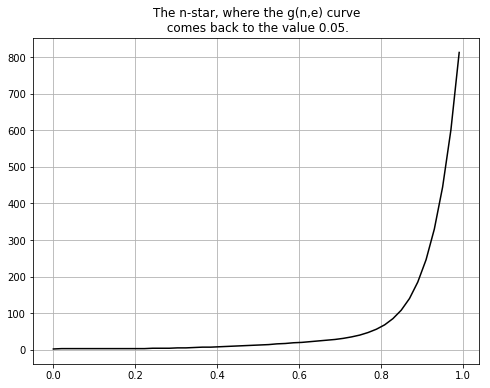

In [11]:
print('n-star(ecc) comes from a fit done in mathematica, see gwtools.py, aNmax(ecc) function.')
ecc = np.linspace(0., 0.99, 50)
nstar = [ gwt.aNmax(uu) for uu in ecc ]
plt.figure( figsize=(8,6) )
plt.plot(ecc, nstar, 'k-')
plt.title('The n-star, where the g(n,e) curve\n comes back to the value 0.05.');
plt.grid(True)

### Check the above function for some eccentricity by plotting $g(n,e)$ versus $0.05$ . 

For example, look at the g(n,e) curve for ecc =  0.9
The n-star is  216.0
max is  17.395364810603994


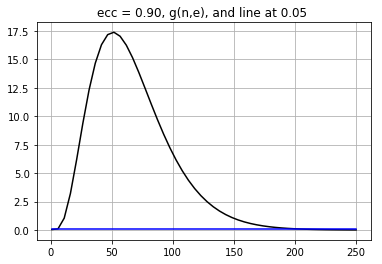

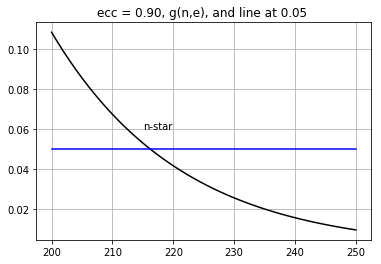

In [12]:
ecc = 0.9 # Eccentricity
print('For example, look at the g(n,e) curve for ecc = ', ecc)
print('The n-star is ', gwt.aNmax(ecc) )
#
# full g(n,e) curve
#
mmin = 1
mmax = 250
modes = np.linspace(mmin,mmax,50)
gne = gwt.ggSimp(modes, ecc)

plt.plot(modes, gne, 'k-')
# The line at 1/20th max is...
yval = 0.05
print('max is ', np.max( gne ) )

plt.plot( [mmin, mmax], [yval, yval], 'b-')
plt.grid(True)
plt.title('ecc = %.2f, g(n,e), and line at 0.05 '%(ecc) )
plt.show()
#
# close up
#
mmin = 200
mmax = 250
modes = np.linspace(mmin,mmax,50)
gne = gwt.ggSimp(modes, ecc)

plt.plot(modes, gne, 'k-')
plt.grid(True)
# The line at 1/20th max is...
yval = 0.05

plt.plot( [mmin, mmax], [yval, yval], 'b-')
plt.title('ecc = %.2f, g(n,e), and line at 0.05 '%(ecc) )
plt.text(215,0.06,'n-star');

## Create a numpy array of GW strain amplitudes for that planet and append to the table.

Using the formula from Amaro-Seoane et al. reference, Eqn. (9)
$$ h_{n} = 2 \sqrt{\frac{32}{5}} \frac{ {\frak M}^{5/3} }{{\mathbf n}\,d_{L}} \big( 2\pi f_{r} \big) \sqrt{ \mathbf {g(n,e)} }$$
where $e$ is the eccentricity, $n$ is the mode number, ${\frak M}$ is the chirp mass $M_{1}^{3/5}M_{2}^{3/5}/(M_{1}+M_{2})^{1/5}$, $d = d_{L}/(1+z)$, and $f_{r}$ is the orbital frequency, so the mode frequency is $f = f_{r}\,n$ for $n=(1,2,3...)$.  I like the chirp mass as $\mu^{3/5} M^{2/5}$ with reduced mass $\mu$ and total mass $M$ for the binary.

The above is found in gwtools.py as  hh(nn, ee, m1, m2, a, dL).

Does not render the above perfectly.  Looks like a font problem on the square root.  Otherwise okay.

In [13]:
help(gwt.hh)  # I do not use this below!!
help(gwt.orbitalFreq)

Help on function hh in module gwTools:

hh(nn, ee, m1, m2, a, dL)
    From Amaro-Seoane et al. 2010, the GW amplitude for GW mode nn in units of
    the orbital frequency, eccentricity ee, binary masses m1 and m2, 
    semi-major axis a, and distance to source dL.  Use SI units.
    Returns the GW amplitude for that frequency mode.
    Amaro-Seoane et al. Eqn. (9), refs Finn and Thorne 2000.

Help on function orbitalFreq in module gwTools:

orbitalFreq(m1, m2, a)
    Given two masses, m1 and m2, and the semimajor axis a,
    return the orbital frequency in Hz from Kepler relations.



In [14]:
aData.head(4)  # To see the headers:)  Just a reminder.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.00,3.03,0.5300,5.100,35.87,0.99,2014-05-14,27.88
1,HD 39091,b,Radial Velocity,2151.00,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.00,0.89,0.3600,0.223,38.45,0.86,2014-05-14,26.01
3,GJ 3021,b,Radial Velocity,133.71,0.49,0.5110,3.370,17.62,0.90,2014-05-14,56.76


### Explicitly use Amaro-Seoane et al. Eqn (9), so that we can see it.  Do NOT use gwt.hh().  Note the physical constants are back, $G^{5/3}/c^{4}$ to make it dimensionless when we use SI units for all the other parameters.

In [15]:
# Actually append n_min, n_max, numpy array of GW strains h.
# In the Mathematica JustStrainPlots.nb, about 40% down, calc hhVfreq first time.

hhmodesCol = []  # Setup a list of the hhmodes that will be appended to the dataframe.
modesCol = []    # The modes set acually used for the calculation, int(modeMin) to int(modeMax)+1
freq0Col = []    # Collect the orbital frequency that was used.

for irow in range(len(aData)):
    # Calculate the SI parameters needed by the strains and the strain "front coefficient."
    
    orbeccen = aData['pl_orbeccen'].values[irow]
    modeMax = gwt.aNmax( orbeccen )  # The "max" mode number where g(n,e) returns to 1/20th its peak value.
    modeMin = gwt.aNmin( orbeccen )  # Either 1 for e>0 or 2 for e=0.
    #
    m1 = aData['pl_bmassj'].values[irow]*massJ
    m2 = aData['st_mass'].values[irow]*massSun
    smax = aData['pl_orbsmax'].values[irow]*au
    dL = aData['st_dist'].values[irow]*pc
    freq0 = 1.0/( aData['pl_orbper'].values[irow]*secsDay )
    # Amaro-Seoane Eqn. (9)...common terms.
    frontCoeff = np.power(bigG,5/3.)/cee**4 * 2 * np.sqrt(32/5.) * np.power( gwt.chirpM(m1,m2), 5/3.)*\
    np.power((2*np.pi*freq0), 2/3.)/dL
    if irow > 6 and irow < 10:
        print('irow is ', irow, ' ,frontCoeff is ', frontCoeff, ' pl_orbeccen is ', orbeccen)

    # Now loop over the GW modes and calc the dim-less strain and the modes used.
    hhmodes = [ frontCoeff* np.sqrt( gwt.ggSimp(uu, orbeccen) )/uu for uu in range(int(modeMin), int(modeMax)+1)  ]
    modes = [ uu for uu in range(int(modeMin), int(modeMax)+1)  ]
    
    # Append to the list.
    hhmodesCol.append( hhmodes )
    modesCol.append( modes )
    freq0Col.append( freq0 )
        

irow is  7  ,frontCoeff is  4.6311021600204593e-26  pl_orbeccen is  0.03
irow is  8  ,frontCoeff is  2.169114619938696e-26  pl_orbeccen is  0.41
irow is  9  ,frontCoeff is  2.5108674723286658e-25  pl_orbeccen is  0.638


In [16]:
# Check there is stuff in there.
print( len(hhmodesCol[0] ) )
print( hhmodesCol[0] )
print( modesCol[0] )

15
[1.8702816437643177e-26, 2.1740658908129503e-26, 2.882158933335889e-26, 2.664860375595358e-26, 2.1935963182104775e-26, 1.7069345750672433e-26, 1.2854210432619556e-26, 9.475882743564367e-27, 6.882115822891534e-27, 4.9437540797700044e-27, 3.5216043707537875e-27, 2.4919659046939435e-27, 1.7539322636285046e-27, 1.2290258111169294e-27, 8.58019444780923e-28]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [17]:
#Append the hhmodesCol to the dataframe, for ease of getting at the other attributes.
aData['freq0'] = freq0Col
aData['modes'] = modesCol
aData['hhmodes'] = hhmodesCol

In [18]:
# Check that appending happened correctly.
aData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes
0,HD 142022 A,b,Radial Velocity,1928.0,3.03,0.5300,5.100,35.87,0.99,2014-05-14,27.88,6.003150e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.8702816437643177e-26, 2.1740658908129503e-2..."
1,HD 39091,b,Radial Velocity,2151.0,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92,5.380788e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[8.230508420052954e-26, 4.507375225359441e-26,..."
2,HD 137388 A,b,Radial Velocity,330.0,0.89,0.3600,0.223,38.45,0.86,2014-05-14,26.01,3.507295e-08,"[1, 2, 3, 4, 5, 6, 7]","[1.6721119496253516e-27, 4.481574164761941e-27..."


### Make a plot of some high eccentricity planet and the modes to double check.

In [19]:
aDataEccen = aData.sort_values(by = 'pl_orbeccen', ascending = False)
aDataEccen.head(3)  #  Looks like Row 304 has eccen 0.9560 and a ton of modes.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes
304,HD 20782,b,Radial Velocity,597.0650,1.397,0.9560,1.43,35.50,1.02,2016-05-19,NaN,1.938495e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2814629622279826e-26, 9.037349908557032e-27..."
3573,HD 80606,b,Radial Velocity,111.4357,0.449,0.9332,3.94,29.04,0.97,2014-05-14,17.13,1.038633e-07,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.30740990715796e-25, 8.506293791204289e-26, ..."
199,HD 4113,b,Radial Velocity,526.6200,1.280,0.9030,1.56,44.05,0.99,2014-12-03,22.70,2.197804e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2594583314652946e-26, 7.233458381856687e-27..."


490    HD 20782


Text(0.5,1,'h modes for planet on star HD 20782 with e = 0.956')

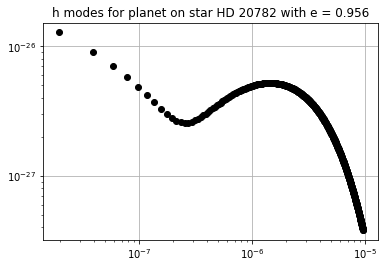

In [20]:
#  Looks like Row 304 has eccen 0.9560 and a ton of modes.
#  Or row 0 of the new dataframe.
irowBig = 304  # index in dataframe, also the same index for aDataEccen.
freq0 = 1.0/( aData['pl_orbper'][irowBig]*secsDay )


xx = np.array(aData['modes'][irowBig]) * freq0
#  Needed the np.array() or saw an error that my list was not AN integer!!
yy = aData['hhmodes'][irowBig]
print( len(xx), '  ', aData['pl_hostname'][irowBig] )

# Plot xx and yy for ONE planet with crazy high eccentricity.
plt.loglog(xx, yy, 'ko')
plt.grid(True)
plt.title('h modes for planet on star %s with e = %.3f' % ( aData['pl_hostname'][irowBig], aData['pl_orbeccen'][irowBig] ) )

### The above looks weird, double check versus the $\sqrt{g(n,e)}/n$ .

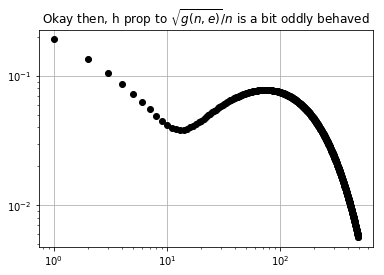

In [21]:
# Above is weird!!
eccen = aData['pl_orbeccen'][304]
xx = np.array( range(1,491) )
yy = [ np.sqrt( gwt.ggSimp(nn, eccen) )/nn for nn in xx ]
plt.loglog(xx, yy, 'ko')
plt.title('Okay then, h prop to $\sqrt{g(n,e)}/n$ is a bit oddly behaved')
plt.grid(True)
# Okay not so weird!!

## Plot All the dimensionless strains for the exops (different colors eventually)
### Replace with a density plot of some kind?

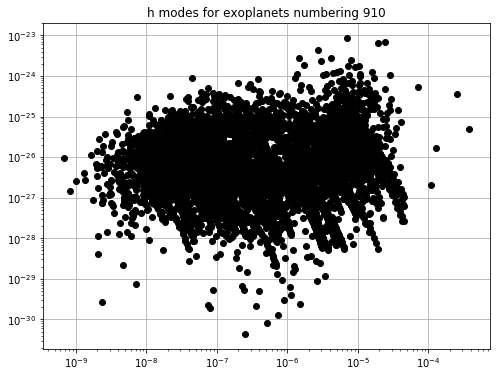

In [22]:
#from matplotlib import cm # for colormap need max number of planets
#myCmap = cm.get_cmap('cool')

#maxNum = len(aData)

# Loop over rows seems easiest.
figAll = plt.figure( figsize=(8,6) )
axAll = figAll.add_subplot((111))

# Seeing other ways to loop over rows, more standard?  .iterrows or .itertuple
for irow in range( len(aData) ):  #  range(4):  # cannot iterate over length, .itertuples() 

    freq0 = 1.0/( aData['pl_orbper'].values[irow]*secsDay )
    xx = np.array( aData['modes'].values[irow] ) * freq0
    #  Needed the np.array() or saw an error that my list was not AN integer!!
    yy = np.array( aData['hhmodes'].values[irow] )

    # Plot xx and yy for ONE planet with crazy high eccentricity.
    #myCmap = plt.colormaps('cool')
    #axAll = plt.loglog(xx, yy, c=0.44, cmap=myCmap)
    axAll.loglog(xx, yy, 'ko')

#plt.colorbar(True)
plt.grid(True)
plt.title('h modes for exoplanets numbering %d' % len(aData) );

## The Noise curve from Shane Larson at CalTech, url below.
## Use the downloaded data that is Amplitude Spectral Density (ASD), and for freq plot want it in dimless strain units (1 year or 4 years) by dividing by sqrt(Int Time), for the SNR need the $S_n(f)$ in per Hz, the Power Spectral Density (PSD) of the expected noise.  

## For the future use the Cornish-Robson noise curve as standard, definitely compare.

The Larson curve from http://www.srl.caltech.edu/~shane/sensitivity/MakeCurve.html .

In [23]:
# Load one or other of the Larson curves into a Panda Dataframe.
larsonASDFile = 'scg_5597_2W_2p5e9m.dat'  # Amplitude Spectral Densities, ASD's in per root Hz!!!
larsonASD = pd.read_csv( thisDir + '/' + larsonASDFile, header=None, delim_whitespace=True, \
                               names=['freq[Hz]', 'ASD[Hz^-1/2]'], skiprows=22 )
larsonASD.head(3)

,freq[Hz],ASD[Hz^-1/2]
0,1.953007e-07,4.115269e-12
1,1.998512e-07,3.929997e-12
2,2.045077e-07,3.753070e-12


In [24]:
# Append the 1 year integrated dimension-less by dividing ASD by sqrt(1 year in secs).  Check this!!
larsonASD['h[dimless,1yr]'] = larsonASD['ASD[Hz^-1/2]'].values/np.sqrt(1.0*secsYear)

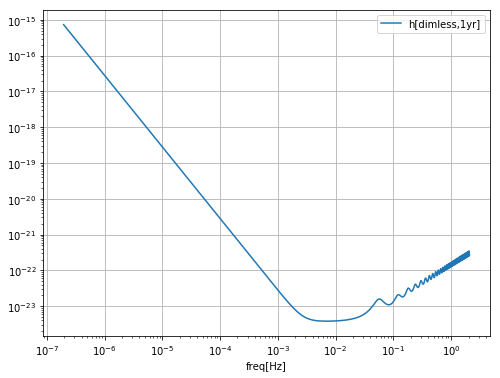

In [25]:
larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,1yr]', logy=True, logx=True, grid=True, figsize=(8,6) )

## The 1 year Larson curve and the individual modes for each exoplanet.

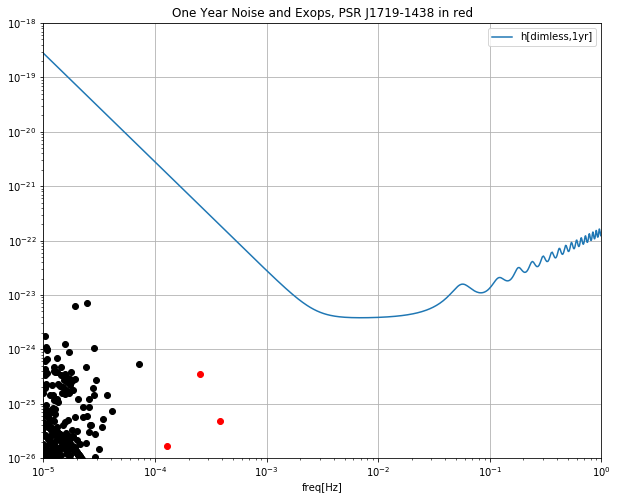

In [26]:
# plotting different dataframes in same plot

ax = larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,1yr]', logy=True, logx=True, grid=True, figsize=(10,8) )
for irow in range(len(aData)):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':  # Flag the brightest one with red dots.
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)
    ax.set_ylim((1e-26, 1e-18) )
    ax.set_xlim((1e-5, 1.0) )
    ax.set_title('One Year Noise and Exops, PSR J1719-1438 in red');
    

In [27]:
# Print the row for exop ...
for irow in range(len(aData) ):
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438' and \
    aData['pl_letter'].values[irow] == 'b':
        theRow = irow
        print( aData.values[irow] )

['PSR J1719-1438' 'b' 'Pulsar Timing' 0.09070629 0.0044 0.06 1.2 1200.0
 1.4 '2014-05-14' nan 0.0001275994649772808 list([1, 2, 3])
 list([1.681497004686017e-26, 3.5797366388109786e-25, 4.8348526229385945e-26])]


In [28]:
gwt.aNmax(0.06)  # If e>0 always have at least three modes, n = 1,2,3 .

3.0

## Calculate the signal-to-noise ratio for each planet.  From matched filtering us $\frac{S}{N}\big)^2 = 2 T \sum_{m=1}^\infty \frac{|h(m f_0)|^2}{S_n(m f_0)}$ , $T$ is integration time, $h$ are the source dimless strains at freq $m f_0$ where $f_0$ is the orbital frequency, and the sum below is truncated at n-star(eccentricity) not $\infty$ .

## Need linear interpolator (or other) for $S_n(f)$ so that I can find $S_n$ at the relevant frequency.

In [29]:
# Will need to interpolate the S_n(f) functions.
# Do the linear interpolation in the log-space since it is so linear there, even a formula for it, I think.
class snLinInterp:

    """Input the numpy arrays of freqs and Sn's and returns a class with
    a __call__ function.  Not good checks for values <=0 or if you are interpolating
    outside the range it was setup in, so use carefully.
    """
    def __init__(self, freqs, sns):
        from scipy.interpolate import interp1d
        # Check lenght of arrays agree.
        if len(freqs) != len(sns):
            print('***class snLinInterp: error, arrays lengths disagree, len(freqs) ', len(freqs), ' and '\
                 'len(sns) is ', len(sns) )
        else:
        # Check for zero in each array.  Cannot use x[x>0] as usual, need arrays coordinated.
            idrop = []
            for ii in range(len(freqs)):
                if freqs[ii] <= 0 or sns[ii] <= 0:
                    idrop.append(ii)

            self.freqs = np.delete(freqs,idrop)
            self.sns = np.delete(sns, idrop)
            self.logFreqs = np.log10(self.freqs)
            self.logSns = np.log10(self.sns)
            self.myInterp1D = interp1d(freqs, sns)  # Leave it linear for now. scipy.interpolate.
            self.minFreq = np.min(self.freqs)
            self.maxFreq = np.max(self.freqs)  # Can only interp between the values min freq and max.
        
    def __call__(self, uu):  # Checking for negatives and zeros is a pain, just do not do it for now!!
        return( self.myInterp1D(uu) )

## Checks on the linear interpolator in the log-space.    
    

Testing the linear interp in log-log space of the dep and indep variables.


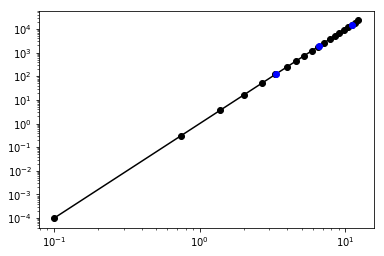

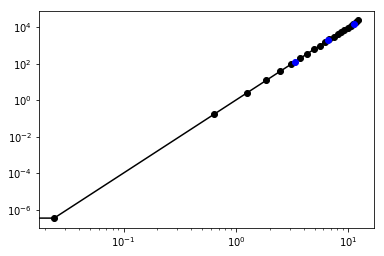

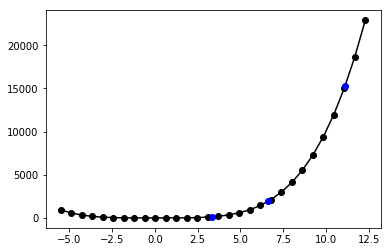

In [30]:
xx = np.linspace(0.1, 12.3, 20)
yy = np.power(xx,4)
snInterp = snLinInterp(xx, yy )  # Has the __call__ method, so makes a 1D function.
xint = [3.33, 6.6, 11.11]
yint = snInterp(xint)
ax = plt.loglog(xx,yy,'ko-', xint, yint, 'bo')
# set_title('Testing the linear interp in log-log space of the dep and indep variables.')
print( 'Testing the linear interp in log-log space of the dep and indep variables.' )
plt.show()

# Test handling of the negatives and zero values!
xx = np.linspace(-5.5, 12.3, 30)
yy = np.power(xx,4)
snInterp2 = snLinInterp(xx, yy) # trying negatives for x but all positives for y, should drop both values.

xint = np.array([3.33, 6.6, 11.11])
yint = snInterp(xint)
plt.loglog(xx,yy,'ko-', xint, yint, 'bo')
plt.show()
plt.plot(xx,yy,'ko-', xint, yint, 'bo')
plt.show()

## Append the PSD to the Noise curve dataframe.

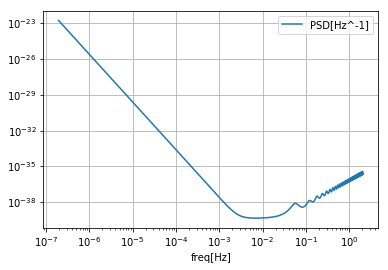

In [31]:
# Append the PSD, per root Hz.  What we need for the SNR**2 formualae.
larsonASD['PSD[Hz^-1]'] = larsonASD['ASD[Hz^-1/2]']**2
larsonASD.plot(x = 'freq[Hz]', y = 'PSD[Hz^-1]', logy=True, logx=True, grid=True)

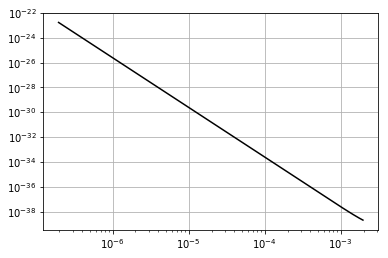

In [32]:
# Setup the interpolating for the S_n(f) in the range below f = 2e-3 Hz.

xfreqsA = larsonASD['freq[Hz]'].values
yPSDA = larsonASD['PSD[Hz^-1]'].values # Define the full data as numpy arrays.

xfreqs = xfreqsA[xfreqsA<=2e-3]  # Use the numpy index selection here.
yPSD = yPSDA[xfreqsA<=2e-3]

plt.loglog( xfreqs, yPSD, 'k-')
plt.grid(True)

In [33]:
mySnInterp = snLinInterp( xfreqs, yPSD )
# To handle the really low frequency modes use the linear fit in the log-log space:
# Larson formula for now.  From Mathematica GWExopSNR.nb
#ssubn[freq_] := 0.1642*10^-48/freq^4
#
# Actually the fit in the python notebook for the left hand side of the S_n(f) from Larson's Sqrt[S_n(f)] 
# was TeXForm[f^-3.9946\cdot 1.6421 \cdot 10^-49]  .
def ssubn(freq):
    return( (0.1642e-48/freq**4) )

# It is the sum over the modes.
intTime = 1.0*secsYear  # Integration time in seconds.

SNRCols = []
for irow in range(len(aData) ):
    freq0 = aData['freq0'].values[irow]
    modes= aData['modes'].values[irow]
    hhmodes = aData['hhmodes'].values[irow]
    SNRSqSum = 0.0
    for jmodes in range(len(modes) ):   # Calc the SQUARE of the SNR!
        amode = modes[jmodes]
        SNRSqSum += 2.0*intTime*hhmodes[jmodes]**2/ssubn(amode*freq0)
#        SNRSqSum += 2.0*intTime*hhmodes[jmodes]**2/mySnInterp(amode*freq0)
    SNRCols.append( np.sqrt(SNRSqSum) )
        
print('len(SNRCols) is ', len(SNRCols) )
aData['SNR']=SNRCols
print('len(aData) is ', len(aData) )
    

len(SNRCols) is  910
len(aData) is  910


In [34]:
# Check the appending of SNR.
aData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
0,HD 142022 A,b,Radial Velocity,1928.0,3.03,0.5300,5.100,35.87,0.99,2014-05-14,27.88,6.003150e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.8702816437643177e-26, 2.1740658908129503e-2...",1.171337e-12
1,HD 39091,b,Radial Velocity,2151.0,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92,5.380788e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[8.230508420052954e-26, 4.507375225359441e-26,...",9.018521e-12
2,HD 137388 A,b,Radial Velocity,330.0,0.89,0.3600,0.223,38.45,0.86,2014-05-14,26.01,3.507295e-08,"[1, 2, 3, 4, 5, 6, 7]","[1.6721119496253516e-27, 4.481574164761941e-27...",1.716782e-12


## Create a dataframe ordered by SNR.

In [35]:
bData = aData.sort_values(by = 'SNR', ascending = False)
bData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
492,PSR J1719-1438,b,Pulsar Timing,0.090706,0.00440,0.0600,1.2000,1200.00,1.40,2014-05-14,NaN,0.000128,"[1, 2, 3]","[1.681497004686017e-26, 3.5797366388109786e-25...",0.000478
156,WASP-18,b,Transit,0.941453,0.02026,0.0092,10.4300,105.49,1.28,2014-05-14,9.48,0.000012,"[1, 2, 3]","[5.044293986239611e-26, 7.052792899222313e-24,...",0.000084
336,PSR J2322-2650,b,Pulsar Timing,0.322964,0.01020,0.0017,0.7949,230.00,1.40,2017-12-21,4.40,0.000036,"[1, 2, 3]","[7.075677179501135e-28, 5.354424563392014e-25,...",0.000054


## Print the table or SNR and other items.

In [36]:
astr = 'name                \teccen\tper(days)\tSNR\tindex\n'
print(astr)
for ii in range(16):
    astr = '%-20s\t%6.4f\t%.3f\t%.3g\t%d'%\
    (bData['pl_hostname'].values[ii]+' '+bData['pl_letter'].values[ii], bData['pl_orbeccen'].values[ii], 
     bData['pl_orbper'].values[ii], 
     bData['SNR'].values[ii], ii)
    print(astr)

name                	eccen	per(days)	SNR	index

PSR J1719-1438 b    	0.0600	0.091	0.000478	0
WASP-18 b           	0.0092	0.941	8.37e-05	1
PSR J2322-2650 b    	0.0017	0.323	5.39e-05	2
KELT-1 b            	0.0099	1.218	4.51e-05	3
WASP-43 b           	0.0000	0.813	1.64e-05	4
tau Boo b           	0.0110	3.312	8.45e-06	5
KELT-9 b            	0.0000	1.481	6.07e-06	6
KELT-16 b           	0.0000	0.969	5.26e-06	7
WASP-77 A b         	0.0000	1.360	5.1e-06	8
WASP-19 b           	0.0020	0.789	4.59e-06	9
WASP-14 b           	0.0910	2.244	3.98e-06	10
HATS-18 b           	0.1660	0.838	3.77e-06	11
HAT-P-2 b           	0.5171	5.633	3.57e-06	12
XO-3 b              	0.2600	3.192	3.54e-06	13
HAT-P-20 b          	0.0150	2.875	3.16e-06	14
HD 73256 b          	0.0290	2.549	2.69e-06	15


## Exops with the highest eccentricity

In [37]:
cData = aData.sort_values(by = 'pl_orbeccen', ascending = False)
cData.head(6)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
304,HD 20782,b,Radial Velocity,597.0650,1.397,0.9560,1.43,35.50,1.02,2016-05-19,NaN,1.938495e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2814629622279826e-26, 9.037349908557032e-27...",1.752908e-08
3573,HD 80606,b,Radial Velocity,111.4357,0.449,0.9332,3.94,29.04,0.97,2014-05-14,17.13,1.038633e-07,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.30740990715796e-25, 8.506293791204289e-26, ...",1.366542e-06
199,HD 4113,b,Radial Velocity,526.6200,1.280,0.9030,1.56,44.05,0.99,2014-12-03,22.70,2.197804e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2594583314652946e-26, 7.233458381856687e-27...",1.713695e-09
23,HD 76920,b,Radial Velocity,415.4000,1.149,0.8560,3.93,184.80,1.17,2017-11-30,NaN,2.786248e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0138731199811866e-26, 4.557659817080447e-27...",5.919106e-10
394,HD 98649,b,Radial Velocity,4951.0000,5.600,0.8500,6.80,42.77,1.00,2014-05-14,23.38,2.337725e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.3095832207217623e-26, 5.675932575080468e-27...",4.693750e-12
12,HD 108341,b,Radial Velocity,1129.0000,2.000,0.8500,3.50,49.40,0.84,2015-01-08,20.23,1.025162e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.3931095245605775e-26, 6.037948261699841e-27...",9.602185e-11


## Cornish and Robson noise curve, see the paper arXiv https://arxiv.org/pdf/1803.01944.pdf

Coded into gwt.lisa_psd() by Katie and does NOT have the white dwarf confusion noise in it...which is the way we want it, I think.  Use all aData as it is here, with SNR from Larson S_n(f).

## Plot the instantaneous h modes on the curve with sqrt of S_n divided by integration time.  This is within factors of a few of the formulae C&R use.

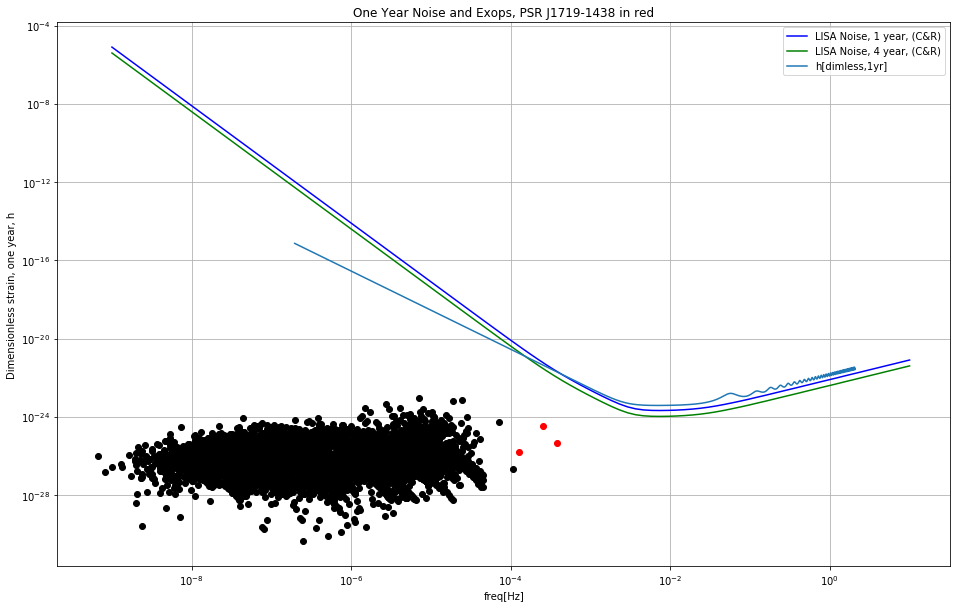

In [38]:
# plotting different dataframes in same plot
afig = plt.figure( figsize=(16,10) )
ax= afig.add_subplot((111))

ff = np.logspace(-9,1,100)
SnCR = gwt.lisa_psd()
y1 = SnCR(ff)
y2 = np.sqrt(y1)/np.sqrt(1.0*secsYear*2)

ax.plot(ff, y2, 'b-', label='LISA Noise, 1 year, (C&R)')

ax.plot(ff, y2/2.0, 'g-', label='LISA Noise, 4 year, (C&R)')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('One Year Noise and Exops, PSR J1719-1438 in red')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Dimensionless strain, one year, h')

# ax = larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,1yr]', logy=True, logx=True, grid=True, figsize=(10,8) )
for irow in range(len(aData)):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':  # Flag the brightest one with red dots.
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)  # , label = 'Exop Modes' Cannot use label because so many plot statements.
    #ax.set_ylim((1e-26, 1e-18) )
    #ax.set_xlim((1e-5, 1.0) )
    #ax.set_title('One Year Noise and Exops, PSR J1719-1438 in red');
    
larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,1yr]', ax = ax, grid=True);

plt.grid(True)
plt.legend()


In [39]:
# copy over the plot rcparmas from PrettyPlotsGWStrain...

# Plot defaults.
params = {'font.size': 24.0,
          'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),  # (14,10)
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#aa = 18.0
#params = {'legend.fontsize': aa,
#          'figure.figsize': (14, 10),
#         'axes.labelsize': aa,
#         'axes.titlesize': aa,
#         'xtick.labelsize': aa,
#         'ytick.labelsize': aa}
plt.rcParams.update(params)
#print(mpl.rcParams)
savePlot = False

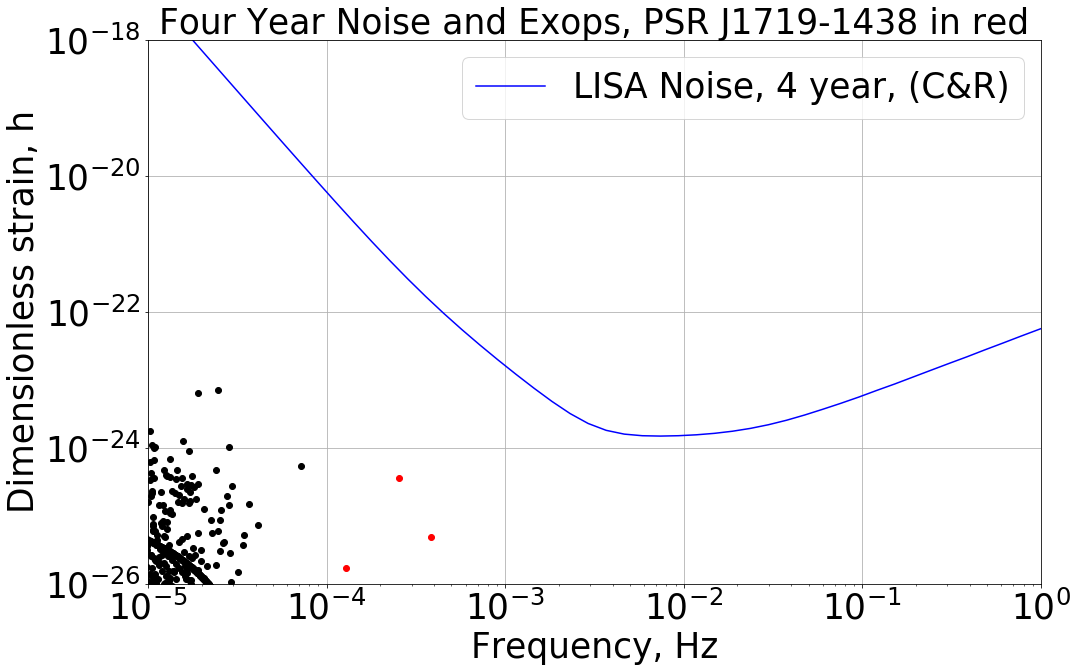

In [40]:
# Plot the exop modes vs sqrt(S_n/T/2)


afig = plt.figure( figsize=(16,10) )
ax= afig.add_subplot((111))

ff = np.logspace(-9,1,100)
SnCR = gwt.lisa_psd()
y1 = SnCR(ff)
y2 = np.sqrt(y1)/np.sqrt(1.0*secsYear)

#ax.plot(ff, y2, 'g-', label='LISA Noise, 1 year, (C&R)')

ax.plot(ff, y2/2.0, 'b-', label='LISA Noise, 4 year, (C&R)')

ax.set_xscale('log')
ax.set_yscale('log')
plt.grid(True)
plt.legend()

ax.set_title('Four Year Noise and Exops, PSR J1719-1438 in red')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Dimensionless strain, h')

# ax = larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,1yr]', logy=True, logx=True, grid=True, figsize=(10,8) )
for irow in range(len(aData)):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':  # Flag the brightest one with red dots.
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)
    ax.set_ylim((1e-26, 1e-18) )
    ax.set_xlim((1e-5, 1.0) )
    #ax.set_title('One Year Noise and Exops, PSR J1719-1438 in red');
    
if savePlot or 1:
    #plt.savefig('../poster/pix/plot_g_n_e.eps')  # Both eps and svg seem to make good PDFs of poster.
    plt.savefig('../poster/pix/plot_hexopVrootSn.svg')